In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from my_functions import *
from load_jpas_catalogs import load_minijpas_jnep

from scipy.stats import binned_statistic

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))

In [3]:
pm_flx, pm_err, tile_id, pmra_sn, pmdec_sn, parallax_sn, starprob, _,\
        spCl, zsp, _, _, _, N_minijpas, x_im, y_im,\
                ra, dec = load_minijpas_jnep(['minijpas', 'jnep'])
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mask_pm = mask_proper_motion(parallax_sn, pmra_sn, pmdec_sn)

/home/alberto/cosmos/LAEs/my_functions.py:35: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(log_arg) - 48.60


In [4]:
N_sources = len(tile_id)
is_minijpas_source = np.ones(N_sources).astype(bool)
is_minijpas_source[N_minijpas:] = False

In [5]:
w_lya = 1215.67 # A

z_nb_Arr = w_central[:-4] / w_lya - 1
print(N_sources)

63923


In [6]:
from minijpas_LF_and_puricomp import nb_or_3fm_cont

ew0_cut = 30
ew_oth = 100
cont_est_m = 'nb'

cont_est_lya, cont_err_lya, cont_est_other, cont_err_other =\
    nb_or_3fm_cont(pm_flx, pm_err, cont_est_m)

# Lya search
line = is_there_line(pm_flx, pm_err, cont_est_lya,
                        cont_err_lya, ew0_cut)
lya_lines, lya_cont_lines, _ = identify_lines(
    line, pm_flx, cont_est_lya, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
                            ew_oth, obs=True, sigma=5)
other_lines = identify_lines(line_other, pm_flx, cont_est_other)

In [7]:
mag_min = 17
mag_max = 24

nb_min, nb_max = 1, 20

mag_cut = (mag > mag_min) & (mag < mag_max)

z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

snr = np.empty(N_sources)
for src in range(N_sources):
    l = lya_lines[src]
    snr[src] = pm_flx[l, src] / pm_err[l, src]

# Drop bad NB image rows
bad_NB_image = np.array([4380, 30395, 30513, 30977, 40306, 43721, 11771, 2583])
mask_bad_NB = np.ones(N_sources).astype(bool)
for bad_nb_src in bad_NB_image:
    mask_bad_NB[bad_nb_src] = False

mask_snr = (snr > 6)
lya_lines_mask = (lya_lines >= nb_min) & (lya_lines <= nb_max)
mask = (lya_lines_mask & mag_cut & mask_snr & mask_bad_NB & mask_pm)

nice_lya_raw, c_mask, ml_mask = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr,
    return_color_mask=True
)
nice_lya_raw = lya_lines_mask & nice_lya_raw & mask_bad_NB & mag_cut
nice_lya = nice_lya_raw & mask & c_mask & ml_mask
sum(nice_lya)

187

In [8]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

In [9]:
L_binning = np.load('npy/L_nb_err_binning.npy')
L_Lbin_err = np.load('npy/L_nb_err.npy')
median_L = np.load('npy/L_bias.npy')

# Apply bin err
L_binning_position = binned_statistic(
        10 ** L_Arr, None, 'count', bins=L_binning
).binnumber
L_binning_position[L_binning_position > len(L_binning) - 2] = len(L_binning) - 2
L_e_Arr = L_Lbin_err[L_binning_position]

L_bin_c = [L_binning[i : i + 1].sum() * 0.5 for i in range(len(L_binning) - 1)]

# Correct L_Arr with the median
L_Arr =  np.log10(10 ** L_Arr - np.interp(10 ** L_Arr, L_bin_c, median_L))

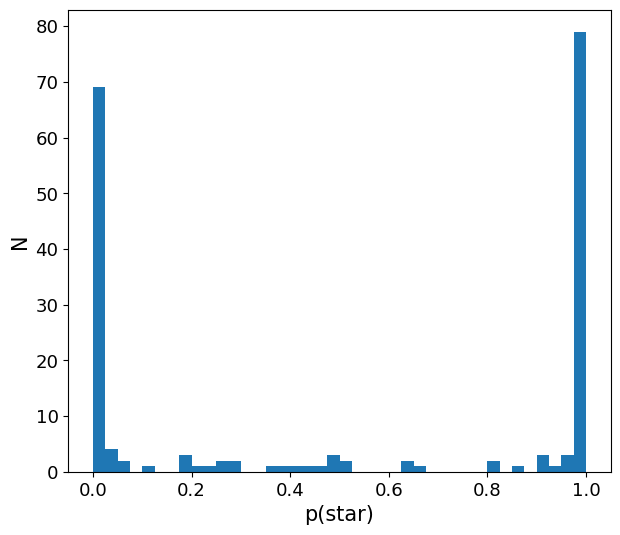

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.hist(starprob[nice_lya], 40)

ax.set_xlabel('p(star)', fontsize=15)
ax.set_ylabel('N', fontsize=15)

plt.show()

187 candidates
43 QSO (21 w/ right z)
3 GALAXY (0 w/ right z)
141 No SDSS counterpart
54 SDSS QSOs with z > 2


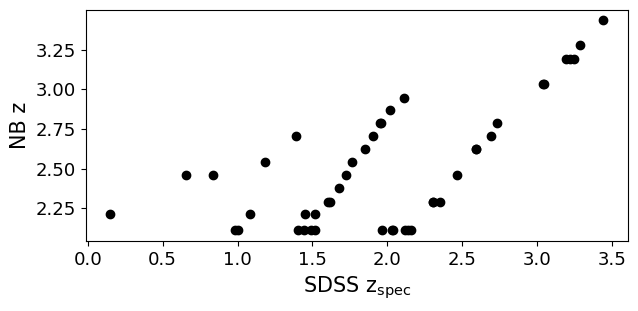

In [11]:
nice_z = (np.abs(z_Arr - zsp) < 0.2)

print('{} candidates'.format(count_true(nice_lya)))
print('{} QSO ({} w/ right z)'.format(count_true(spCl[nice_lya] == 'QSO'), count_true((spCl[nice_lya] == 'QSO') & nice_z[nice_lya])))
print('{} GALAXY ({} w/ right z)'.format(count_true(spCl[nice_lya] == 'GALAXY'), count_true((spCl[nice_lya] == 'GALAXY') & nice_z[nice_lya])))
print('{} No SDSS counterpart'.format(count_true(spCl[nice_lya].astype(str) == 'nan')))
print('{} SDSS QSOs with z > 2'.format(sum(zsp > 2)))

fig, ax = plt.subplots(figsize=(7, 3))

ax.scatter(zsp[nice_lya], z_Arr[nice_lya], c='k')

ax.set_xlabel('SDSS z$_\mathrm{spec}$', fontsize=15)
ax.set_ylabel('NB z', fontsize=15)

plt.show()

In [12]:
def nanomaggie_to_flux(nmagg, wavelength):
    mAB = -2.5 * np.log10(nmagg * 1e-9)
    flx = mag_to_flux(mAB, wavelength)
    return flx

tile_id, number = load_minijpas_jnep(selection=True)[4:6]


26
spec-7028-56449-0937.fits
Selected: False, zspec = 2.28, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (14.39)


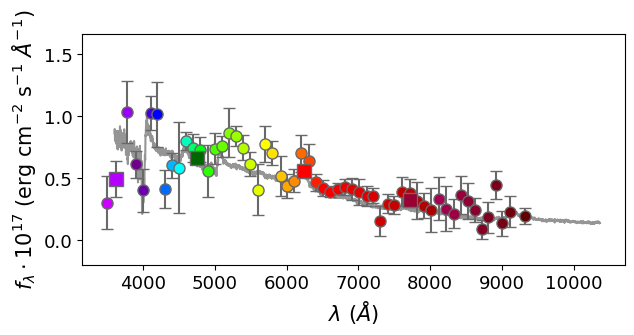

spec-7339-56799-0899.fits
Selected: False, zspec = 2.73, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (18.36)


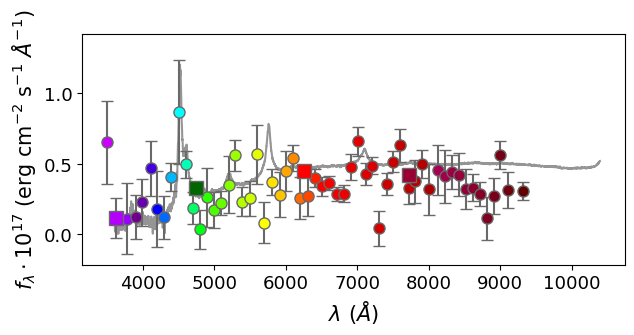

spec-7027-56448-0994.fits
Selected: False, zspec = 2.85, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (28.14)


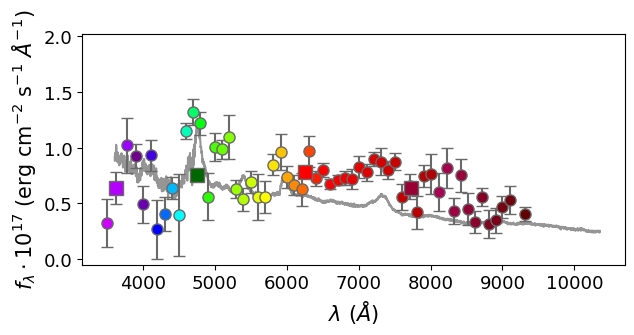

spec-7338-56717-0078.fits
Selected: False, zspec = 4.29, Z_WARNINGS = 0
L_lya = 45.00
ML = True, Color = True, S/N = True (39.13)


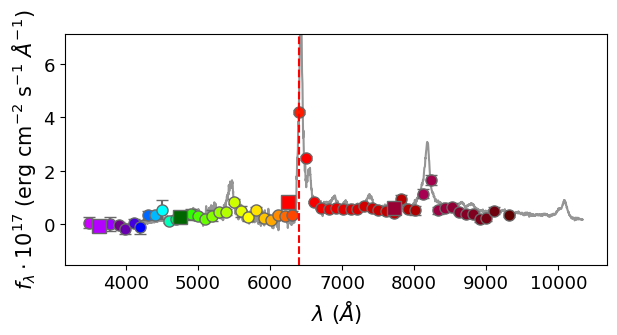

spec-5017-55715-0240.fits
Selected: False, zspec = 3.10, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (17.38)


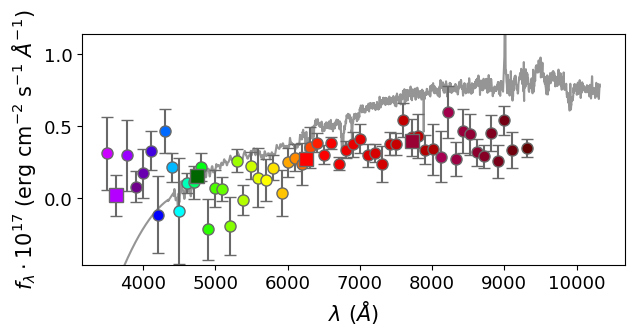

spec-7028-56449-0933.fits
Selected: False, zspec = 3.04, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (9.78)


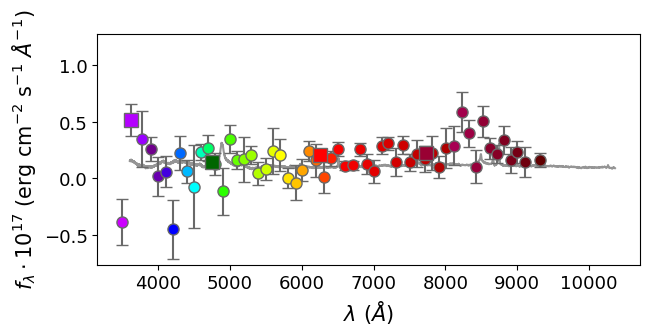

spec-7032-56471-0652.fits
Selected: False, zspec = 4.27, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (67.20)


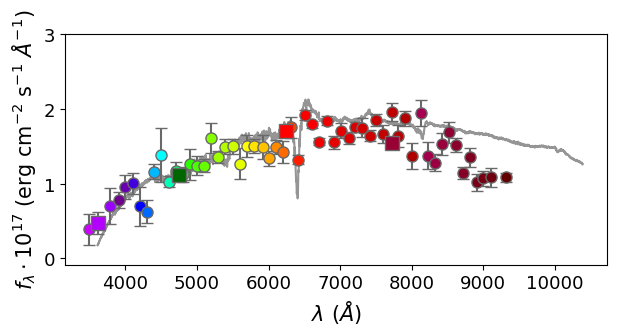

spec-7027-56448-0068.fits
Selected: False, zspec = 2.58, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (72.85)


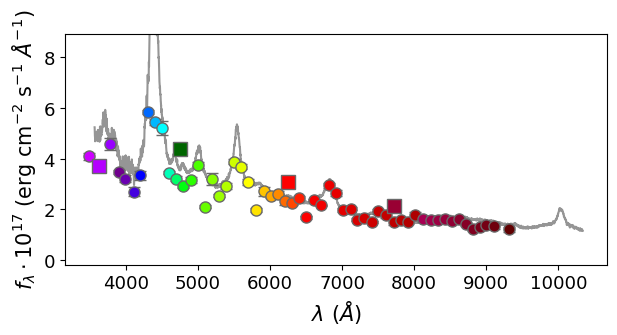

spec-7339-56768-0060.fits
Selected: False, zspec = 2.17, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (12.87)


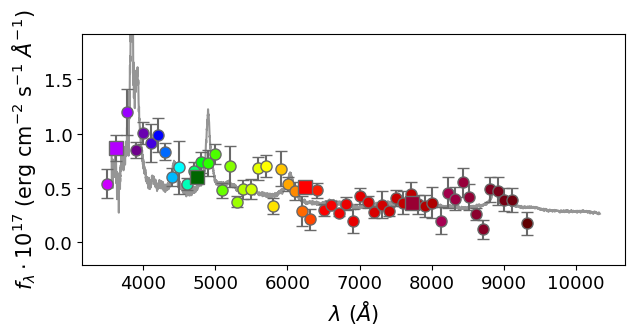

spec-7031-56449-0602.fits
Selected: False, zspec = 5.85, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (31.87)


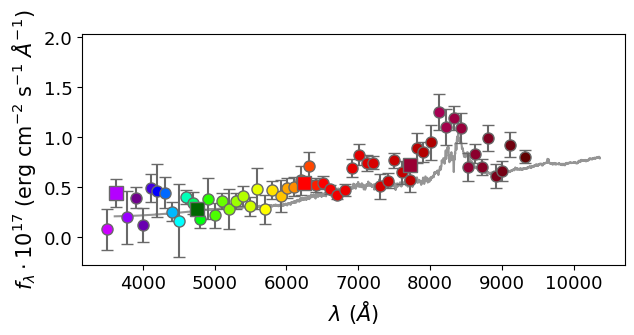

spec-5017-55715-0820.fits
Selected: False, zspec = 3.13, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (17.03)


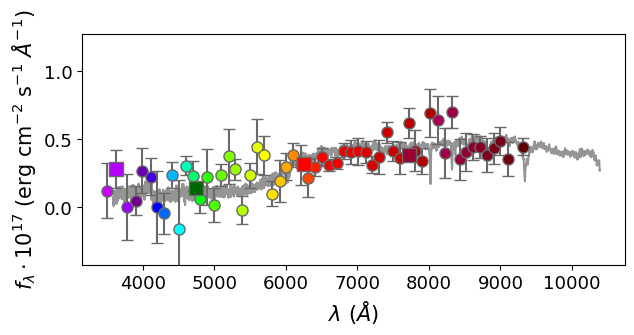

spec-7029-56455-0284.fits
Selected: False, zspec = 3.31, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (16.26)


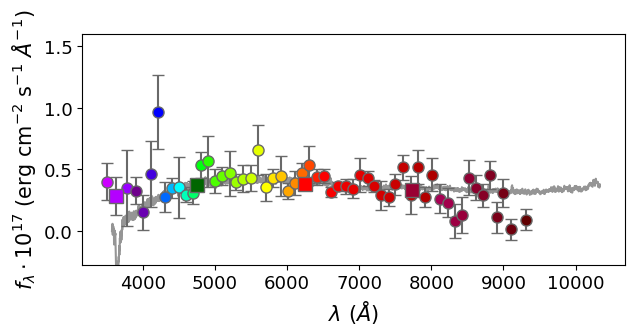

spec-7029-56455-0289.fits
Selected: False, zspec = 3.15, Z_WARNINGS = 4
L_lya = nan
ML = True, Color = True, S/N = True (16.22)


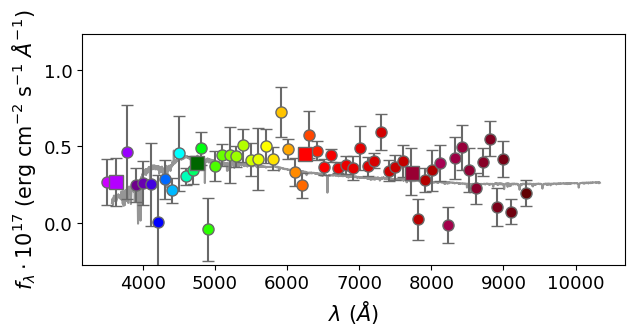

spec-7340-56837-0258.fits
Selected: False, zspec = 2.48, Z_WARNINGS = 0
L_lya = nan
ML = True, Color = True, S/N = True (18.26)


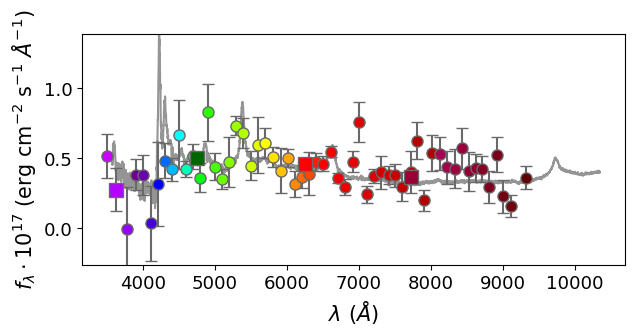

spec-1326-52764-0091.fits
Selected: False, zspec = 2.42, Z_WARNINGS = 192
L_lya = nan
ML = True, Color = True, S/N = True (428.95)


KeyError: 'MODEL'

<Figure size 700x300 with 0 Axes>

In [14]:
from visual_inspection import load_sdss_xmatch
sdss_xm_num, sdss_xm_tid, sdss_xm_spObjID, f_zsp = load_sdss_xmatch() 

# Directory of the spectra .fits files
fits_dir = '/home/alberto/almacen/SDSS_spectra_fits/miniJPAS_Xmatch'

wh = (zsp > 2.12) & ~nice_lya & (lya_lines > 0)
print(sum(wh))
for src in np.where(wh)[0]:
    sdss_src = (number[src] == sdss_xm_num) & (tile_id[src] == sdss_xm_tid)
    this_spObjID = sdss_xm_spObjID.to_numpy()[sdss_src][0]
    zw = f_zsp[sdss_src].to_numpy().astype(int)[0]
    # Disgregate SpObjID in mjd, tile, fiber
    spObj_binary = np.binary_repr(this_spObjID)
    plate = int(spObj_binary[::-1][50:64][::-1], 2)
    mjd = int(spObj_binary[::-1][24:38][::-1], 2) + 50000
    fiber = int(spObj_binary[::-1][38:50][::-1], 2)

    spec_name = f'spec-{plate:04d}-{mjd:05d}-{fiber:04d}.fits'
    print(spec_name)
    print(f'Selected: {nice_lya[src]}, zspec = {zsp[src]:0.2f}, Z_WARNINGS = {zw}')
    print(f'L_lya = {L_Arr[src]:0.2f}')
    print(f'ML = {ml_mask[src]}, Color = {c_mask[src]}, S/N = {mask_snr[src]} ({snr[src]:0.2f})')
    spec_bool = True
    spec = Table.read(f'{fits_dir}/{spec_name}', hdu=1, format='fits')
    g_band = Table.read(f'{fits_dir}/{spec_name}', hdu=2, format='fits')['SPECTROFLUX']
    g_band = nanomaggie_to_flux(np.array(g_band)[0][1], 4750)

    fig = plt.figure(figsize=(7, 3))

    if g_band is not None and spec is not None:
        # Normalizing factor:
        norm = pm_flx[-3, src] / g_band
        spec_flx = spec['MODEL'] * norm
        spec_w = 10 ** spec['LOGLAM']

        ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src], e17scale=True)
        ax.plot(spec_w, spec_flx, c='dimgray', zorder=-99, alpha=0.7)
    
    if lya_lines[src] > 0:
        ax.axvline(w_central[lya_lines[src]], c='r', ls='--')
    
    plt.show()